# DataLoader

In [4]:
from PIL import Image
from torch.utils.data import Dataset
import glob

In [44]:
# int(glob.glob('./datasets/images/*')[0].split('/')[-1].split('.')[0].split('_')[-1])

1

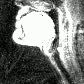

In [39]:
img = Image.open(glob.glob('./datasets/images/*')[0])
img

In [5]:
from torchvision import transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        # transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        # transforms.Normalize(mean, std)
    ]),
}

In [22]:
min(3,5)

3

In [1]:
from PIL import Image
from torch.utils.data import Dataset
import glob

class span75speaker(Dataset):
    def __init__(self, image_path = './datasets/images', audio_path = './datasets/audios', transform=None, target_transform=None):
        self.images = glob.glob(f'{image_path}/*')  # Could be a list: ['./train/input/image_1.bmp', './train/input/image_2.bmp', ...]
        # self.audios = glob.glob(f'{audio_path}/*')  # Could be a nested list: [['./train/GT/image_1_1.bmp', './train/GT/image_1_2.bmp', ...], ['./train/GT/image_2_1.bmp', './train/GT/image_2_2.bmp', ...]]
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, index):
        image_name = self.images[index].split('/')[-1].split('.')[0].split('-')
        img = Image.open(self.images[index])
        if self.transform:
            img = self.transform(img)

        aud_embs = torch.load(f'./datasets/audios/{image_name[0]}.pt')
        aud_emb = aud_embs[:,min(int(image_name[-1]), aud_embs.size(1) - 1),:]

        return (img, aud_emb)

    def __len__(self):
        return len(self.images)

In [6]:
traindata = span75speaker(transform = data_transforms['val'])
(img, aud) = next(iter(traindata))

NameError: name 'torch' is not defined

In [16]:
aud.shape

torch.Size([1, 1024])

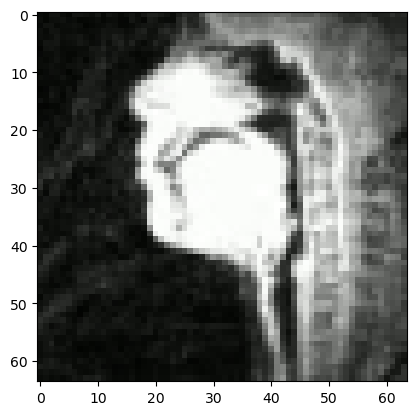

In [17]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1, 2, 0))

# Data Pre-processing

### Preprocess Audio

In [8]:
import librosa
import torch
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

In [19]:
# import librosa
# import torch
# from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

input_audio, sample_rate = librosa.load("/mnt/c/Users/PCM/Dropbox/span/sub006/2drt/audio/sub006_2drt_01_vcv1_r1_video.wav",  sr=16000)

model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

i= feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
with torch.no_grad():
  o= model(i.input_values)

print(o.keys())
print(o.last_hidden_state.shape)
print(o.extract_features.shape)

odict_keys(['last_hidden_state', 'extract_features'])
torch.Size([1, 1413, 1024])
torch.Size([1, 1413, 512])


In [20]:
o.last_hidden_state.size(1)

1413

In [104]:
# aud_list = glob.glob(f'/mnt/c/Users/PCM/Dropbox/span/sub006/2drt/audio/*')[0]
# aud_list.split('/')[-1].split('.')[0]

'sub006_2drt_01_vcv1_r1_video'

In [9]:
def create_audio_emds(in_path = '/mnt/c/Users/PCM/Dropbox/span/sub006/2drt/audio', out_path = './datasets/audios'):
    aud_list = glob.glob(f'{in_path}/*')
    for path in aud_list:
        name = path.split('/')[-1].split('.')[0]
        input_audio, sample_rate = librosa.load(f"{in_path}/{name}.wav",  sr=16000)

        model_name = "facebook/wav2vec2-large-xlsr-53"
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
        model = Wav2Vec2Model.from_pretrained(model_name)

        i= feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)
        with torch.no_grad():
            o = model(i.input_values)
        torch.save(o.last_hidden_state, f'{out_path}/{name}.pt')

# create_audio_emds(in_path = '/mnt/c/Users/PCM/Dropbox/span/sub006/2drt/audio', out_path = './datasets/audios/')

In [21]:
aaa = torch.load('/mnt/c/Users/PCM/Documents/GitHub/SPAN-rtmri/datasets/audios/sub001_2drt_01_vcv1_r2_video.pt')
aaa.shape

torch.Size([1, 1685, 1024])

In [ ]:
subjects = glob.glob('/mnt/c/Users/PCM/Dropbox/span/sub*')
for sub in subjects:
    create_audio_emds(in_path = f'{sub}/2drt/audio', out_path = './datasets/audios')

### Preprocess Video

In [ ]:
import glob
import subprocess

subjects = glob.glob('/mnt/c/Users/PCM/Dropbox/span/sub*')
for sub in subjects:
    vids = glob.glob(f'{sub}/2drt/video/*')
    # audio_foler = f'{sub}/2drt/audio'
    # subprocess.call(f'mkdir {audio_foler}', shell=True)
    for i in range(len(vids)):
        command = f"ffmpeg -i {vids[i]} -r 50 ./datasets/images/{vids[i].split('/')[-1].split('.')[0]}-%d.png"
        subprocess.call(command, shell=True)
        # !ffmpeg -i vids[i] -r 50 f'./datasets/images/{vids[i].split('/')[-1].split('.')[0]}-%d.png'

Sample video to frames in 50 fps

In [ ]:
!ffmpeg -i '/mnt/c/Users/PCM/Dropbox/span/sub006/2drt/video/sub006_2drt_01_vcv1_r1_video.mp4' -r 50 './datasets/images/sub006_2drt_01_vcv1_r1_video-%d.png'

# Modeling

In [ ]:
import torch
# from imagen_pytorch import Unet, Imagen
from imagen_pytorch import Unet, Imagen, ImagenTrainer
# from imagen_pytorch.data import Dataset
# unet for imagen

unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    text_embed_dim=1024,
    unets = (unet1, unet2),
    image_sizes = (64, 64),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

# mock images (get a lot of this) and text encodings from large T5

# text_embeds = o.extract_features.view(1413,1,512)[:10].cuda #torch.randn(1, 1, 512).cuda()
# images = torch.randn(1, 3, 64, 64).cuda()

dataset = span75speaker(transform = data_transforms['val'])

trainer = ImagenTrainer(
    imagen = imagen,
    split_valid_from_train = True # whether to split the validation dataset from the training
).cuda()
trainer.add_train_dataset(dataset, batch_size = 32)

for i in range(1,200000):
    loss = trainer.train_step(unet_number = 1, max_batch_size = 32)
    print(f'loss: {loss}')

    if not (i % 50):
        valid_loss = trainer.valid_step(unet_number = 1, max_batch_size = 32)
        print(f'valid loss: {valid_loss}')

    if not (i % 100) and trainer.is_main: # is_main makes sure this can run in distributed
        images = trainer.sample(text_embeds = aud.unsqueeze(0), batch_size = 1, return_pil_images = True, stop_at_unet_number=1) # returns List[Image]
        images[0].save(f'./sample_log/sample-{i // 100}.png')

# feed images into imagen, training each unet in the cascade

# for i in (1, 2):
#     loss = imagen(images, text_embeds = text_embeds, unet_number = i)
#     loss.backward()

# do the above for many many many many steps
# now you can sample an image based on the text embeddings from the cascading ddpm

# images = imagen.sample(texts = [
#     'a whale breaching from afar',
#     'young girl blowing out candles on her birthday cake',
#     'fireworks with blue and green sparkles'
# ], cond_scale = 3.)

# images.shape # (3, 3, 256, 256)

In [30]:
torch.save(imagen.state_dict(), './imagen-span-070823')

In [31]:
unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)

unet2 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    text_embed_dim=1024,
    unets = (unet1, unet2),
    image_sizes = (64, 64),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()

imagen.load_state_dict(torch.load('./imagen-span-070823'))
imagen.eval()

Imagen(
  (noise_schedulers): ModuleList(
    (0): GaussianDiffusionContinuousTimes()
    (1): GaussianDiffusionContinuousTimes()
  )
  (lowres_noise_schedule): GaussianDiffusionContinuousTimes()
  (unets): ModuleList(
    (0): Unet(
      (init_conv): CrossEmbedLayer(
        (convs): ModuleList(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (2): Conv2d(3, 8, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
        )
      )
      (to_time_hiddens): Sequential(
        (0): LearnedSinusoidalPosEmb()
        (1): Linear(in_features=17, out_features=128, bias=True)
        (2): SiLU()
      )
      (to_time_cond): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
      )
      (to_time_tokens): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): Rearrange('b (r d) -> b r d', r=2)
      )
      (

In [13]:

images = imagen.sample(text_embeds = torch.randn(1, 1, 512).cuda(), cond_scale = 3.)

images.shape # (3, 3, 256, 256)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 3, 64, 64])